In [1]:
import gensim
import os
import collections
import smart_open
import random
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from pprint import pprint
import numpy as np
from sklearn import svm
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
import time

/home/hao/anaconda3/envs/MLOntology/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#global variabls

directory_path =  "/home/hao/AnacondaProjects/MLOntology/NCIt/"
data_path = directory_path + "data/"
vector_model_path = directory_path +"vectorModel/"
cnn_model_path = directory_path +"cnnModel/"


In [3]:
import re
def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

In [4]:
#read class label file
#create mapping from id to labels  
#iso-8859-1 , encoding="iso-8859-1"
conceptLabelDict={}
errors=[]

def read_label(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                conceptID = get_trailing_number(splitted[1])
                conceptLabelDict[conceptID] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

label_file = data_path + "ontClassLabels_owl_ncit.txt"
read_label(label_file)
print(conceptLabelDict["4863"])
print(conceptLabelDict["115117"])
print(errors)

prostate carcinoma
stage ia esophageal cancer ajcc v7
[]


In [52]:
conceptPairDict={}
errors=[]
conceptPairList=[]

def read_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                childID = get_trailing_number(splitted[1])
                parentID = get_trailing_number(splitted[2].replace("\r\n", ""))
                conceptPairList.append([childID, parentID , 1])
#                 conceptPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

pair_file = data_path + "ontHierarchy_owl_ncit.txt"
read_pair(pair_file)

checkpairs = conceptPairList[10:15]
print(checkpairs)
print(len(conceptPairList))

[['4861', '7318', 1], ['87152', '87150', 1], ['87153', '140032', 1], ['87154', '87153', 1], ['87155', '87153', 1]]
16533


In [53]:
conceptNotPairDict={}
conceptNotPairList=[]

def read_not_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==2:
                childID = get_trailing_number(splitted[0])
                notparentID = get_trailing_number(splitted[1].replace("\r\n", ""))
                conceptNotPairList.append([childID, notparentID, 0])
#                 conceptNotPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

notPair_file = data_path + "taxNotPairs_owl_ncit.txt"
read_not_pair(notPair_file)


first2pairs =conceptNotPairList[10:15]
print(first2pairs)
print(len(conceptNotPairList))

[['7918', '9151', 0], ['7918', '48612', 0], ['7918', '48613', 0], ['7918', '91231', 0], ['7918', '66753', 0]]
37147


In [ ]:


print(len(conceptPairList))

In [54]:
if len(conceptPairList) < len(conceptNotPairList):
    # In-place shuffle
    random.shuffle(conceptNotPairList)
    leftPairList = conceptNotPairList[len(conceptPairList):]
    conceptNotPairList = conceptNotPairList[:len(conceptPairList)]
else:
    # In-place shuffle
    random.shuffle(conceptPairList)
    leftPairList = conceptPairList[len(conceptNotPairList):]
    conceptPairList = conceptPairList[:len(conceptNotPairList)]

assert len(conceptPairList) == len(conceptNotPairList), "Mistmatch in POS&NEG samples!"



In [55]:
print(len(leftPairList))

20614


In [41]:
#  PV-DBOW
vector_model_file = vector_model_path + "model0"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

[('7576', 0.7686420679092407),
 ('82862', 0.7540969848632812),
 ('4495', 0.7524679899215698),
 ('4229', 0.7506747245788574),
 ('3804', 0.7484248876571655),
 ('4486', 0.7465652227401733),
 ('3033', 0.7464011311531067),
 ('4234', 0.745087742805481),
 ('3803', 0.7450522184371948),
 ('3694', 0.7374510765075684)]


In [9]:
# PV-DM seems better??
vector_model_file = vector_model_path + "model1"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

[('8965', 0.49586647748947144),
 ('3694', 0.49576500058174133),
 ('4562', 0.49446868896484375),
 ('7158', 0.4795208275318146),
 ('4557', 0.47393715381622314),
 ('5665', 0.4628344178199768),
 ('7045', 0.4492914378643036),
 ('114940', 0.44915124773979187),
 ('3810', 0.44833317399024963),
 ('5365', 0.44617414474487305)]


In [ ]:
vector_model.docvecs['7918']

In [10]:
def readFromPairList(id_pair_list, id_notPair_list):
    pair_list = id_pair_list + id_notPair_list
    random.shuffle(pair_list)
    idpairs_list =[]
    label_list =[]
    for i, line in enumerate(pair_list):      
        idpairs_list.append([line[0], line[1]])
        label_list.append(line[2])
    return idpairs_list, label_list

idpairs_list, label_list= readFromPairList(conceptPairList, conceptNotPairList)

print(label_list[:20])

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(idpairs_list, label_list, test_size = 0.2, shuffle= True)
print(X_train[:20])
print(X_validation[:20])
print(y_train[:20])
print(y_validation[:20])

[['96948', '96810'], ['3574', '3061'], ['7355', '7716'], ['134615', '7711'], ['89476', '2917'], ['6682', '88888'], ['115225', '3851'], ['27721', '3406'], ['148065', '7055'], ['27267', '7340'], ['43535', '7724'], ['4723', '5305'], ['133564', '35180'], ['39644', '68838'], ['7469', '7489'], ['6148', '4122'], ['3127', '3156'], ['7194', '8968'], ['5860', '5029'], ['27392', '43329']]
[['8791', '54663'], ['115432', '6283'], ['9360', '3211'], ['7152', '8923'], ['27889', '91201'], ['7082', '7081'], ['4670', '40406'], ['115370', '9045'], ['5488', '27439'], ['133005', '133003'], ['9347', '3646'], ['134614', '7121'], ['8068', '27809'], ['4862', '36255'], ['6002', '8771'], ['27293', '7653'], ['133592', '4937'], ['2857', '7364'], ['7404', '7398'], ['27859', '4342']]
[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]
[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]


In [31]:
features = 256 # 128 + 128

def getVectorFromModel(concept_id, conceptLabelDict, model):
    if concept_id in model.docvecs:
        concept_vector= model.docvecs[concept_id]
    else:
        print("%s not found, get inferred vector "%(concept_id))
        concept_label = conceptLabelDict[concept_id]
        concept_vector= model.infer_vector(concept_label.split())
    return concept_vector

def getVector(line, conceptLabelDict, model):        
    a = getVectorFromModel(line[0], conceptLabelDict, model)
    b = getVectorFromModel(line[1], conceptLabelDict, model)
    c = np.array((a, b))
    c = np.reshape(c, (256,1), order='F')
#     c = c.T 
#     c = np.expand_dims(c, axis=2)
#     print(c.shape)
    return c

In [ ]:
def stackVector(vector):
    from numpy import dstack
    return dstack((vector, vector, vector))

In [32]:
n_classes=2 

def get_batches(x_samples, y_samples, batch_size=64):
    samples = list(zip(x_samples, y_samples))
    num_samples = len(samples)
    
    shuffle(samples)
    for offset in range(0, num_samples, batch_size):
        batch_samples = samples[offset:offset+batch_size]

        X_samples = []
        Y_samples= []
        for batch_sample in batch_samples:
            pair_list = batch_sample[0]
            data_vector = getVector(pair_list, conceptLabelDict, vector_model)
#                 data_vector = stackVector(data_vector)
#             print(data_vector.shape)
            X_samples.append(data_vector)
            class_label = batch_sample[1] 
            Y_samples.append(class_label)

        X_samples = np.array(X_samples).astype('float32')
        Y_samples = np.eye(n_classes)[Y_samples]
#             print('one batch ready')
        yield shuffle(X_samples, Y_samples)

def get_batches(X, y, batch_size = 100):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [42]:
# Imports
import tensorflow as tf

# build the model??
batch_size = 1000       # Batch size
seq_len = 256          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 2
n_channels = 1


graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

    
with graph.as_default():
    # (batch, 256, 1) --> (batch, 128, 9)
    conv0 = tf.layers.conv1d(inputs=inputs_, filters=9, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_0 = tf.layers.max_pooling1d(inputs=conv0, pool_size=2, strides=2, padding='same')
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=max_pool_0, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')


with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



In [15]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [43]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    training_start_time = time.time()
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 50 iters
            if (iteration % 50 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc)
                      )
            
            # Compute validation loss at every 100 iterations
            if (iteration%100 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_validation, y_validation, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    training_duration = time.time() - training_start_time
    print("Total training time: {} sec".format(training_duration))
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/500 Iteration: 50 Train loss: 0.685435 Train acc: 0.540000
Epoch: 1/500 Iteration: 100 Train loss: 0.677512 Train acc: 0.617500
Epoch: 1/500 Iteration: 100 Validation loss: 0.674008 Validation acc: 0.683048
Epoch: 2/500 Iteration: 150 Train loss: 0.652459 Train acc: 0.680000
Epoch: 2/500 Iteration: 200 Train loss: 0.607811 Train acc: 0.677500
Epoch: 2/500 Iteration: 200 Validation loss: 0.584217 Validation acc: 0.741615
Epoch: 3/500 Iteration: 250 Train loss: 0.592736 Train acc: 0.710000
Epoch: 4/500 Iteration: 300 Train loss: 0.502282 Train acc: 0.770000
Epoch: 4/500 Iteration: 300 Validation loss: 0.504274 Validation acc: 0.757637
Epoch: 5/500 Iteration: 350 Train loss: 0.478823 Train acc: 0.770000
Epoch: 5/500 Iteration: 400 Train loss: 0.472114 Train acc: 0.787500
Epoch: 5/500 Iteration: 400 Validation loss: 0.464137 Validation acc: 0.783187
Epoch: 6/500 Iteration: 450 Train loss: 0.421783 Train acc: 0.825000
Epoch: 7/500 Iteration: 500 Train loss: 0.433389 Train acc: 0.79

Epoch: 55/500 Iteration: 3750 Train loss: 0.363845 Train acc: 0.825000
Epoch: 56/500 Iteration: 3800 Train loss: 0.310034 Train acc: 0.880000
Epoch: 56/500 Iteration: 3800 Validation loss: 0.358346 Validation acc: 0.835124
Epoch: 57/500 Iteration: 3850 Train loss: 0.352487 Train acc: 0.827500
Epoch: 58/500 Iteration: 3900 Train loss: 0.372352 Train acc: 0.835000
Epoch: 58/500 Iteration: 3900 Validation loss: 0.353219 Validation acc: 0.837528
Epoch: 58/500 Iteration: 3950 Train loss: 0.334994 Train acc: 0.832500
Epoch: 59/500 Iteration: 4000 Train loss: 0.346290 Train acc: 0.865000
Epoch: 59/500 Iteration: 4000 Validation loss: 0.353075 Validation acc: 0.838154
Epoch: 60/500 Iteration: 4050 Train loss: 0.331351 Train acc: 0.842500
Epoch: 61/500 Iteration: 4100 Train loss: 0.411800 Train acc: 0.805000
Epoch: 61/500 Iteration: 4100 Validation loss: 0.351374 Validation acc: 0.837969
Epoch: 61/500 Iteration: 4150 Train loss: 0.395044 Train acc: 0.805000
Epoch: 62/500 Iteration: 4200 Train l

Epoch: 111/500 Iteration: 7450 Train loss: 0.367276 Train acc: 0.837500
Epoch: 111/500 Iteration: 7500 Train loss: 0.352657 Train acc: 0.827500
Epoch: 111/500 Iteration: 7500 Validation loss: 0.330555 Validation acc: 0.851530
Epoch: 112/500 Iteration: 7550 Train loss: 0.310524 Train acc: 0.867500
Epoch: 113/500 Iteration: 7600 Train loss: 0.346823 Train acc: 0.827500
Epoch: 113/500 Iteration: 7600 Validation loss: 0.333564 Validation acc: 0.849324
Epoch: 114/500 Iteration: 7650 Train loss: 0.306149 Train acc: 0.867500
Epoch: 114/500 Iteration: 7700 Train loss: 0.376737 Train acc: 0.825000
Epoch: 114/500 Iteration: 7700 Validation loss: 0.325335 Validation acc: 0.854656
Epoch: 115/500 Iteration: 7750 Train loss: 0.346558 Train acc: 0.837500
Epoch: 116/500 Iteration: 7800 Train loss: 0.323198 Train acc: 0.847500
Epoch: 116/500 Iteration: 7800 Validation loss: 0.326971 Validation acc: 0.853147
Epoch: 117/500 Iteration: 7850 Train loss: 0.310813 Train acc: 0.857500
Epoch: 117/500 Iteration

Epoch: 165/500 Iteration: 11100 Train loss: 0.321339 Train acc: 0.842500
Epoch: 165/500 Iteration: 11100 Validation loss: 0.306741 Validation acc: 0.864432
Epoch: 166/500 Iteration: 11150 Train loss: 0.306965 Train acc: 0.860000
Epoch: 167/500 Iteration: 11200 Train loss: 0.292571 Train acc: 0.875000
Epoch: 167/500 Iteration: 11200 Validation loss: 0.306067 Validation acc: 0.864305
Epoch: 167/500 Iteration: 11250 Train loss: 0.266669 Train acc: 0.897500
Epoch: 168/500 Iteration: 11300 Train loss: 0.283695 Train acc: 0.885000
Epoch: 168/500 Iteration: 11300 Validation loss: 0.305872 Validation acc: 0.865443
Epoch: 169/500 Iteration: 11350 Train loss: 0.306646 Train acc: 0.852500
Epoch: 170/500 Iteration: 11400 Train loss: 0.302590 Train acc: 0.865000
Epoch: 170/500 Iteration: 11400 Validation loss: 0.305451 Validation acc: 0.865168
Epoch: 170/500 Iteration: 11450 Train loss: 0.364219 Train acc: 0.845000
Epoch: 171/500 Iteration: 11500 Train loss: 0.298605 Train acc: 0.862500
Epoch: 171/

Epoch: 219/500 Iteration: 14700 Train loss: 0.274151 Train acc: 0.880000
Epoch: 219/500 Iteration: 14700 Validation loss: 0.294834 Validation acc: 0.870129
Epoch: 220/500 Iteration: 14750 Train loss: 0.292371 Train acc: 0.865000
Epoch: 220/500 Iteration: 14800 Train loss: 0.323831 Train acc: 0.870000
Epoch: 220/500 Iteration: 14800 Validation loss: 0.294728 Validation acc: 0.870864
Epoch: 221/500 Iteration: 14850 Train loss: 0.286046 Train acc: 0.872500
Epoch: 222/500 Iteration: 14900 Train loss: 0.301408 Train acc: 0.867500
Epoch: 222/500 Iteration: 14900 Validation loss: 0.293182 Validation acc: 0.871600
Epoch: 223/500 Iteration: 14950 Train loss: 0.318007 Train acc: 0.865000
Epoch: 223/500 Iteration: 15000 Train loss: 0.342587 Train acc: 0.845000
Epoch: 223/500 Iteration: 15000 Validation loss: 0.296098 Validation acc: 0.869727
Epoch: 224/500 Iteration: 15050 Train loss: 0.301069 Train acc: 0.855000
Epoch: 225/500 Iteration: 15100 Train loss: 0.346986 Train acc: 0.827500
Epoch: 225/

Epoch: 273/500 Iteration: 18300 Train loss: 0.316044 Train acc: 0.852500
Epoch: 273/500 Iteration: 18300 Validation loss: 0.283738 Validation acc: 0.878051
Epoch: 273/500 Iteration: 18350 Train loss: 0.326334 Train acc: 0.850000
Epoch: 274/500 Iteration: 18400 Train loss: 0.305273 Train acc: 0.840000
Epoch: 274/500 Iteration: 18400 Validation loss: 0.292874 Validation acc: 0.872297
Epoch: 275/500 Iteration: 18450 Train loss: 0.323028 Train acc: 0.857500
Epoch: 276/500 Iteration: 18500 Train loss: 0.279744 Train acc: 0.890000
Epoch: 276/500 Iteration: 18500 Validation loss: 0.283467 Validation acc: 0.877022
Epoch: 276/500 Iteration: 18550 Train loss: 0.255269 Train acc: 0.882500
Epoch: 277/500 Iteration: 18600 Train loss: 0.339008 Train acc: 0.842500
Epoch: 277/500 Iteration: 18600 Validation loss: 0.303240 Validation acc: 0.865660
Epoch: 278/500 Iteration: 18650 Train loss: 0.288980 Train acc: 0.855000
Epoch: 279/500 Iteration: 18700 Train loss: 0.239909 Train acc: 0.902500
Epoch: 279/

Epoch: 326/500 Iteration: 21900 Train loss: 0.223260 Train acc: 0.900000
Epoch: 326/500 Iteration: 21900 Validation loss: 0.280862 Validation acc: 0.877668
Epoch: 327/500 Iteration: 21950 Train loss: 0.321011 Train acc: 0.857500
Epoch: 328/500 Iteration: 22000 Train loss: 0.274407 Train acc: 0.870000
Epoch: 328/500 Iteration: 22000 Validation loss: 0.280233 Validation acc: 0.878953
Epoch: 329/500 Iteration: 22050 Train loss: 0.244028 Train acc: 0.887500
Epoch: 329/500 Iteration: 22100 Train loss: 0.332862 Train acc: 0.867500
Epoch: 329/500 Iteration: 22100 Validation loss: 0.276711 Validation acc: 0.881306
Epoch: 330/500 Iteration: 22150 Train loss: 0.280104 Train acc: 0.870000
Epoch: 331/500 Iteration: 22200 Train loss: 0.290826 Train acc: 0.867500
Epoch: 331/500 Iteration: 22200 Validation loss: 0.277918 Validation acc: 0.879100
Epoch: 332/500 Iteration: 22250 Train loss: 0.239660 Train acc: 0.885000
Epoch: 332/500 Iteration: 22300 Train loss: 0.263489 Train acc: 0.887500
Epoch: 332/

Epoch: 380/500 Iteration: 25500 Train loss: 0.267509 Train acc: 0.885000
Epoch: 380/500 Iteration: 25500 Validation loss: 0.291515 Validation acc: 0.870168
Epoch: 381/500 Iteration: 25550 Train loss: 0.262558 Train acc: 0.882500
Epoch: 382/500 Iteration: 25600 Train loss: 0.233439 Train acc: 0.892500
Epoch: 382/500 Iteration: 25600 Validation loss: 0.270325 Validation acc: 0.884886
Epoch: 382/500 Iteration: 25650 Train loss: 0.239573 Train acc: 0.902500
Epoch: 383/500 Iteration: 25700 Train loss: 0.265684 Train acc: 0.880000
Epoch: 383/500 Iteration: 25700 Validation loss: 0.274646 Validation acc: 0.880532
Epoch: 384/500 Iteration: 25750 Train loss: 0.238753 Train acc: 0.882500
Epoch: 385/500 Iteration: 25800 Train loss: 0.283058 Train acc: 0.877500
Epoch: 385/500 Iteration: 25800 Validation loss: 0.271645 Validation acc: 0.881983
Epoch: 385/500 Iteration: 25850 Train loss: 0.306418 Train acc: 0.870000
Epoch: 386/500 Iteration: 25900 Train loss: 0.284741 Train acc: 0.880000
Epoch: 386/

Epoch: 434/500 Iteration: 29100 Train loss: 0.222713 Train acc: 0.892500
Epoch: 434/500 Iteration: 29100 Validation loss: 0.263975 Validation acc: 0.887591
Epoch: 435/500 Iteration: 29150 Train loss: 0.270681 Train acc: 0.890000
Epoch: 435/500 Iteration: 29200 Train loss: 0.304268 Train acc: 0.880000
Epoch: 435/500 Iteration: 29200 Validation loss: 0.263594 Validation acc: 0.888345
Epoch: 436/500 Iteration: 29250 Train loss: 0.271215 Train acc: 0.882500
Epoch: 437/500 Iteration: 29300 Train loss: 0.205685 Train acc: 0.922500
Epoch: 437/500 Iteration: 29300 Validation loss: 0.263575 Validation acc: 0.887591
Epoch: 438/500 Iteration: 29350 Train loss: 0.254209 Train acc: 0.892500
Epoch: 438/500 Iteration: 29400 Train loss: 0.249286 Train acc: 0.907500
Epoch: 438/500 Iteration: 29400 Validation loss: 0.265013 Validation acc: 0.887719
Epoch: 439/500 Iteration: 29450 Train loss: 0.234417 Train acc: 0.907500
Epoch: 440/500 Iteration: 29500 Train loss: 0.270491 Train acc: 0.885000
Epoch: 440/

Epoch: 488/500 Iteration: 32700 Train loss: 0.246523 Train acc: 0.910000
Epoch: 488/500 Iteration: 32700 Validation loss: 0.262049 Validation acc: 0.888767
Epoch: 488/500 Iteration: 32750 Train loss: 0.208106 Train acc: 0.917500
Epoch: 489/500 Iteration: 32800 Train loss: 0.219733 Train acc: 0.920000
Epoch: 489/500 Iteration: 32800 Validation loss: 0.259747 Validation acc: 0.889924
Epoch: 490/500 Iteration: 32850 Train loss: 0.263307 Train acc: 0.897500
Epoch: 491/500 Iteration: 32900 Train loss: 0.259574 Train acc: 0.882500
Epoch: 491/500 Iteration: 32900 Validation loss: 0.259675 Validation acc: 0.890532
Epoch: 491/500 Iteration: 32950 Train loss: 0.195445 Train acc: 0.917500
Epoch: 492/500 Iteration: 33000 Train loss: 0.299963 Train acc: 0.855000
Epoch: 492/500 Iteration: 33000 Validation loss: 0.268113 Validation acc: 0.884394
Epoch: 493/500 Iteration: 33050 Train loss: 0.231036 Train acc: 0.880000
Epoch: 494/500 Iteration: 33100 Train loss: 0.228266 Train acc: 0.905000
Epoch: 494/

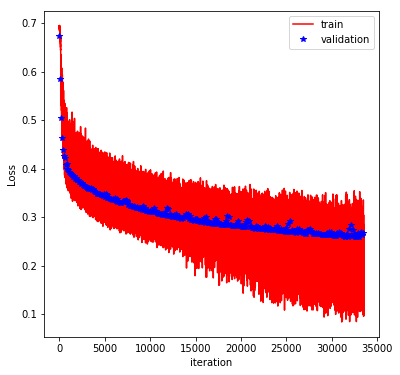

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 100 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.savefig('loss.png') 

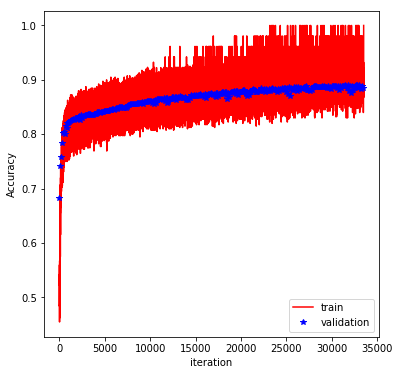

<Figure size 432x288 with 0 Axes>

In [51]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 100 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
plt.savefig('accuracy.png') 

In [46]:
testStrings = '''4092,3677,1
4556,4555,1
4408,4242,1
62210,4133,1
4459,84509,1
6750,2896,1
3942,7158,1
3754,65157,1
3084,65157,1
6985,65157,1
3061,65157,1
27939,65157,1
4139,2915,1
3058,2937,1
4047,2937,1
7335,3010,1
3375,9343,1
4150,45921,1'''

X_test = []
y_test = []
X_test_reverse = []

for line in testStrings.splitlines():
    word = line.replace("\r\n", "").split(",")
    X_test.append([word[0], word[1]])
    X_test_reverse.append([word[1], word[0]])
    y_test.append(int(word[2]))
#     print(word)
#     print(vector_model.docvecs[word[0]])
#     print(vector_model.docvecs[word[1]])

print(len(X_test))

18


In [47]:
print(X_test)
print(y_test)

[['4092', '3677'], ['4556', '4555'], ['4408', '4242'], ['62210', '4133'], ['4459', '84509'], ['6750', '2896'], ['3942', '7158'], ['3754', '65157'], ['3084', '65157'], ['6985', '65157'], ['3061', '65157'], ['27939', '65157'], ['4139', '2915'], ['3058', '2937'], ['4047', '2937'], ['7335', '3010'], ['3375', '9343'], ['4150', '45921']]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [48]:
for pair in X_test:
    if pair in X_train or pair in X_validation:
        print(pair, ' yes')
        X_test.remove(pair)

print(len(X_test))

['7335', '3010']  yes
17


In [49]:
test_acc = []
batch_size = len(X_test)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.176471
